# Do Zip Codes with Large Parks have Higher Dog Density than those without? Are the dog and cat populations different ages? 
## Hypothesis Testing Reminder/Primer with Python's Stats Package, and other things you never thought to ask about registered pets in Seattle

## Import necessary packages

In [13]:
import geopandas as gpd
import pandas as pd
%matplotlib inline

## Load data from csv

Note: seattle_zip_code_pet_density.csv is generated in this[https://github.com/allisonhonold/geospatial_data_blog/blob/master/geospatial_blog.ipynb] jupyter notebook. See below for the conversion from string to shapely geometry

In [3]:
pets_zips = pd.read_csv('data/seattle_zip_code_pet_density.csv')
pets = pd.read_csv('data/Seattle_Pet_Licenses.csv')

In [5]:
pets_zips.head()

,Unnamed: 0,ZIP,geometry,area,pets,pet_density
0,0,98101,POLYGON ((-122.3278536012117 47.61849675280555...,0.000163,696,4.259932e+06
1,1,98102,POLYGON ((-122.3123241071172 47.64705007992422...,0.000481,1640,3.412311e+06
2,2,98112,MULTIPOLYGON (((-122.3068257351625 47.64729480...,0.000981,1895,1.932635e+06
3,3,98115,POLYGON ((-122.2729415289972 47.70106980982185...,0.002019,4541,2.249664e+06
4,4,98116,"POLYGON ((-122.381388745373 47.59054151926219,...",0.000905,2366,2.615165e+06


In [6]:
pets.head()

,License Issue Date,License Number,Animal's Name,Species,Primary Breed,Secondary Breed,ZIP Code
0,April 19 2003,200097,Tinkerdelle,Cat,Domestic Shorthair,NaN,98116
1,February 07 2006,75432,Pepper,Cat,Manx,Mix,98103
2,May 21 2014,727943,Ashley,Cat,Domestic Shorthair,NaN,98115
3,May 08 2015,833836,Lulu,Cat,LaPerm,NaN,98136
4,May 13 2015,361031,My Boy,Cat,Russian Blue,NaN,98121


## Import Shape Files for Seattle Parks

In [8]:
parks_gdf = gpd.read_file('data/shapes/Seattle_Parks.shp')

In [74]:
parks_gdf.head()

,OBJECTID,NAME,PMA_NAME,ADDRESS,PIN,SUBPARCEL,PMA,OWNER,LEASE,MAINT,...,98133,98134,98144,98146,98155,98117,98177,98178,98199,98195
0,1,JACKSON PARK GOLF COURSE,Jackson Park Golf Course,None,5101407870,636.0,327,DPR,N,DPR,...,False,False,False,False,True,False,False,False,False,False
1,2,BURKE-GILMAN TRAIL,Burke-Gilman Trail,None,2226049009,675.0,476,DPR,N,DPR,...,False,False,False,False,False,False,False,False,False,False
2,3,LITTLE BROOK PARK,Little Brook Park,None,7663700850,1663.0,297,DPR,N,DPR,...,False,False,False,False,False,False,False,False,False,False
3,4,HELENE MADISON POOL,Helene Madison Pool,None,1926049035,525.0,285,None,None,DPR,...,True,False,False,False,False,False,False,False,False,False
4,5,MAGNOLIA BOULEVARD,Magnolia Boulevard,None,2225039999,674.0,2843,DPR,None,DPR,...,False,False,False,False,False,False,False,False,True,False


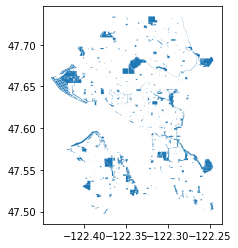

In [27]:
parks_gdf.plot()

## Convert Zip Code geometry from string to shapely / geopandas

In [23]:
from shapely import wkt
pets_zips['geometry'] = pets_zips['geometry'].apply(wkt.loads)
pets_zips_gdf = gpd.GeoDataFrame(pets_zips, geometry='geometry')

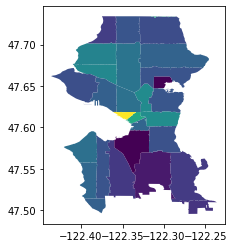

In [26]:
pets_zips_gdf.plot(column='pet_density')

## Classify Parks into Zip Codes

In [94]:
for zip_code in pets_zips_gdf['ZIP']:
    # get the geometry of the zipcode
    zip_code_geometry = pets_zips_gdf.loc[pets_zips['ZIP'] == zip_code, 'geometry']
    zip_code_geometry = zip_code_geometry.reset_index(drop=True)
    
    # check if each park is in the zipcode, store result
    parks_gdf[str(zip_code)] = parks_gdf.intersects(zip_code_geometry[0])

In [95]:
parks_gdf.head(1).T

,0
OBJECTID,1
NAME,JACKSON PARK GOLF COURSE
PMA_NAME,Jackson Park Golf Course
ADDRESS,None
PIN,5101407870
...,...
98117,False
98177,False
98178,False
98199,False


## Decide on "Large Park" Boundary and Get "large parks" zipcodes

Ravenna park's size: 50 acres

In [96]:
ravenna_park = parks_gdf.loc[parks_gdf['NAME'] == 'RAVENNA PARK']
large_park_area = ravenna_park['SHAPE_Area'].sum()

In [97]:
large_parks = parks_gdf.loc[parks_gdf['SHAPE_Area']>= large_park_area]

In [98]:
large_parks.head(1).T

,0
OBJECTID,1
NAME,JACKSON PARK GOLF COURSE
PMA_NAME,Jackson Park Golf Course
ADDRESS,None
PIN,5101407870
...,...
98117,False
98177,False
98178,False
98199,False


In [110]:
parks_in_zips = {zip_code: large_parks[str(zip_code)].sum() for zip_code in pets_zips_gdf['ZIP']}

In [111]:
parks_in_zips

{98101: 0,
 98102: 0,
 98112: 1,
 98115: 2,
 98116: 1,
 98136: 1,
 98103: 3,
 98104: 0,
 98105: 0,
 98106: 2,
 98107: 0,
 98108: 2,
 98109: 0,
 98118: 4,
 98119: 0,
 98121: 0,
 98122: 0,
 98125: 1,
 98126: 2,
 98133: 0,
 98134: 0,
 98144: 1,
 98146: 0,
 98155: 1,
 98117: 0,
 98177: 2,
 98178: 0,
 98199: 3,
 98195: 0}

In [115]:
no_parks_zips = [zip_code for zip_code in parks_in_zips.keys() if parks_in_zips[zip_code]==0]

In [116]:
parks_zips = [zip_code for zip_code in parks_in_zips.keys() if parks_in_zips[zip_code]>0]

## Calculate Dog Density

## Hypothesis Testing

In [ ]:
park_zips_dogs = 

In [ ]:
no_park_zips_dogs = 

## Other Fun Facts

### Histogram of Pet Names

### Top Dog Names vs. Top Cat Names vs. Highest overlapping cat and dog names

### Top Cat Breeds, Top Dog Breeds

### Non-standard animal locations

### Longtime pet residents